# 1. EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.inspection import permutation_importance

import catboost as cat

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [2]:
dfc = pd.read_csv('credit_risk_dataset.csv')
dfc.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


In [3]:
df1 = dfc.copy()

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
df1.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
for column in df1.select_dtypes(include='object'):
    print(df1[column].value_counts())
    print("................................................")

RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64
................................................
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64
................................................
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64
................................................
N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64
................................................


In [7]:
df1.select_dtypes(include='object').nunique()

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

The categorical data only consist small number of unique values. I will use __one-hot-encoding__ to transform the categorical data later

In [8]:
df1.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


It's surprising that the maximum of __person_age__ is 144 and the maximum __person_emp_length__ is 123 (years). We will see later about these data

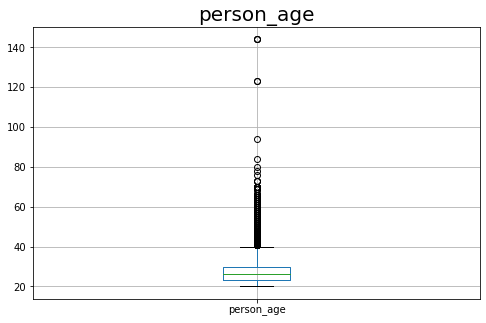

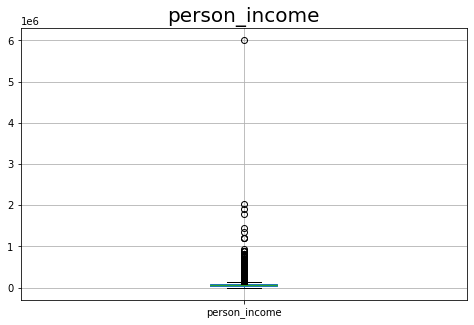

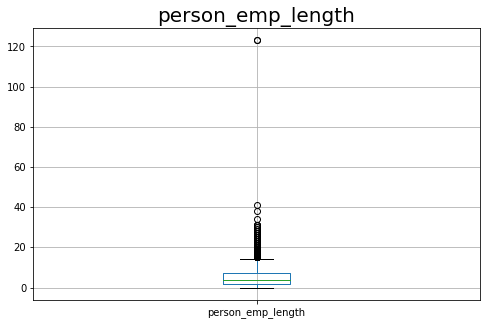

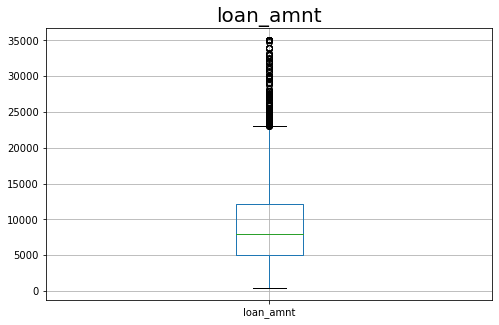

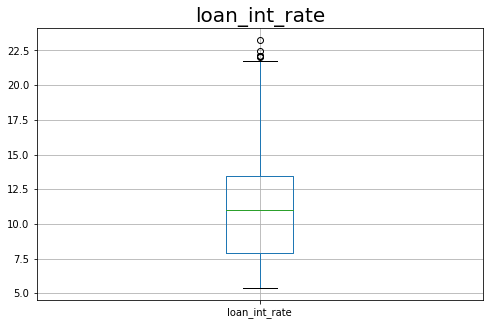

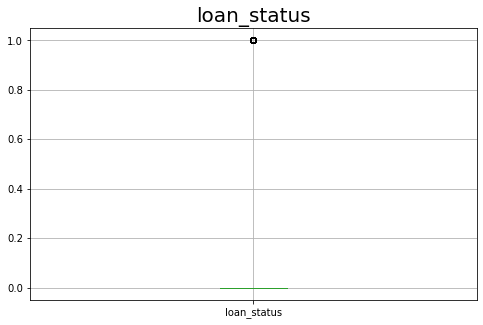

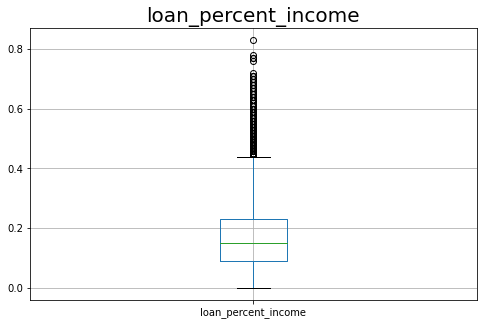

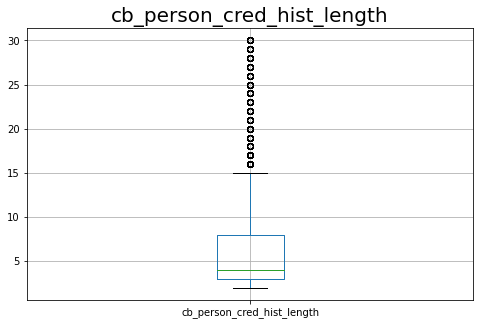

In [9]:
for column in df1.select_dtypes(exclude=['object']):
    plt.figure(figsize=(8,5))
    df1[[column]].boxplot()
    plt.title(column, fontsize=20)
    plt.show()

- __person_age__ there are person who is more than 100 years old
- __person_income__ there an outlier that stated the income is $6 x 10^6$ while the others are less than $2 x 10^6$. This should not be overlooked
- __person_emp_length__ there is an outlier that stated the person already have been employed 120+ years. This will be only makes senses if the person is the one in his/her 144 years old 

### 1.1 Identifying Outliers

In [10]:
df1.sort_values(by=['person_age'], ascending=False).head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0,0.27,N,27
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0,0.11,N,24
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,0,0.11,N,25
32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25
32534,76,75000,RENT,23.0,MEDICAL,A,15000,8.94,0,0.20,N,25


In [11]:
df1.sort_values(by=['person_emp_length'], ascending=False).head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4
32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25
32515,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0,0.19,N,23
32428,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,1,0.15,Y,24


The __person_age__ who has 123 (years) __person_emp_length__ is just in their 20's. It doesn't make sense for a person to have been employed for more than their age. So we could assume it is miss input, and will make it to be null for now

In [12]:
df1['person_emp_length'] = df1['person_emp_length'].replace(123, None)

In [13]:
df1.sort_values(by=['person_emp_length'], ascending=False).head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25
32515,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0,0.19,N,23
32428,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,1,0.15,Y,24
31867,46,180000,MORTGAGE,31.0,VENTURE,B,18000,9.91,0,0.10,N,11
30914,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,9000,14.54,0,0.13,N,17


### Missing Values

<AxesSubplot:xlabel='person_emp_length', ylabel='Density'>

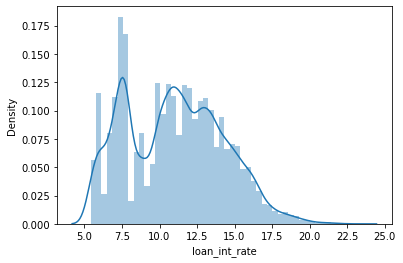

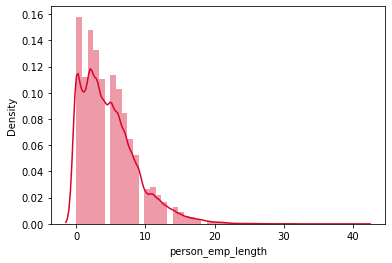

In [14]:
plt.figure()
sns.distplot(df1['loan_int_rate'].dropna())

plt.figure()
sns.distplot(df1['person_emp_length'].dropna(), color= '#d90429')

The distributions aren't normal distribution, it's more like right skewed distribution. So i will use median to fill the missing value

### Correlation

In [15]:
def get_corr(data,col):
    cor = data.corr(method = 'spearman')[col].sort_values(ascending =False)
    print(cor)

In [16]:
df1.corr(method = 'spearman')['loan_status'].sort_values(ascending =False)

loan_status                   1.000000
loan_int_rate                 0.320062
loan_percent_income           0.316115
loan_amnt                     0.084032
cb_person_cred_hist_length   -0.023779
person_age                   -0.033354
person_income                -0.272131
Name: loan_status, dtype: float64

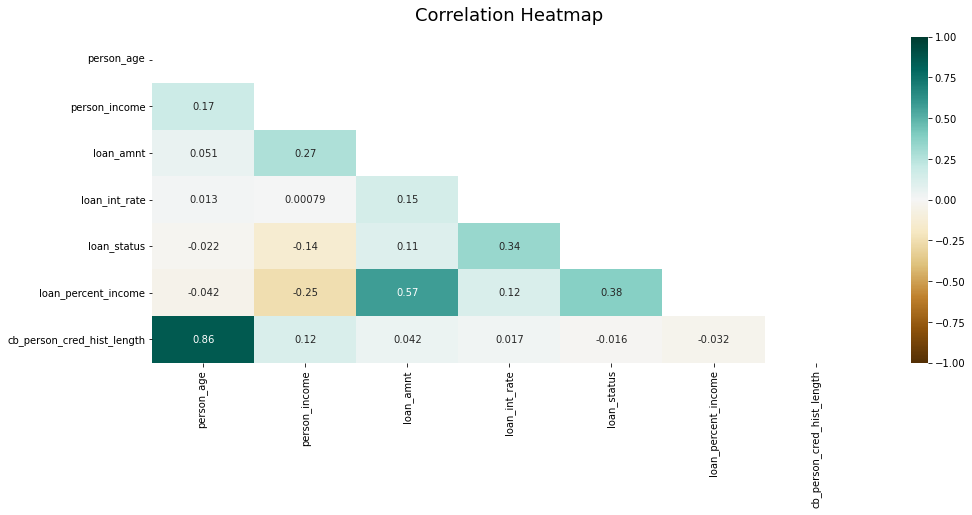

In [17]:
np.triu(np.ones_like(df1.corr()))

plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df1.corr(), dtype=np.bool))
heatmap = sns.heatmap(df1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

There are some high correlation between the features that might cause multicollinearity. The features that have high correlation are:
- __person_age__ and __cb_person_cred_hist_length__: 0.86
- __loan_percent_income__ with __loan_amnt__: 0.57

In [18]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif.sort_values(by=['VIF'], ascending=False))

In [19]:
X = df1.select_dtypes(exclude='object')
calc_vif(X.dropna())

,variables,VIF
0,person_age,26.943267
3,loan_int_rate,11.536063
5,loan_percent_income,7.905515
6,cb_person_cred_hist_length,7.389328
2,loan_amnt,7.018258
1,person_income,3.219385
4,loan_status,1.683790


As we expected before, there is variables that have high VIF, VIF $\ge$ 10. I will try drop person_age and see the results

In [20]:
df1.drop(columns = ['person_age'], axis = 1, inplace = True)

In [21]:
X = df1.select_dtypes(exclude='object')
calc_vif(X.dropna())

,variables,VIF
4,loan_percent_income,7.016060
1,loan_amnt,6.913992
2,loan_int_rate,5.779573
0,person_income,2.878012
5,cb_person_cred_hist_length,2.838705
3,loan_status,1.603976


Now all of the VIF < 10

# 3. Data Transformation

In [22]:
random_seed = 0
test_size = 0.3
data = df1.copy()

target = 'loan_status'
median_list = ['person_emp_length', 'loan_int_rate']
num_col = [col for col in data.select_dtypes(exclude ='object') if col != target]
cat_col = [col for col in data.select_dtypes(include ='object')]

In [23]:
X = data.drop(columns = target)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = test_size, random_state = random_seed)

In [24]:
num_imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
encoder = OneHotEncoder(handle_unknown="ignore")

num_transformer = make_pipeline(num_imputer)
scaler_transformer = make_pipeline(num_transformer, scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, median_list), 
                  ('scale', scaler_transformer, num_col),
                  ('cat', cat_transformer, cat_col),])

# 4. Feature Importance

### 4.1 Random Forest Modeling

In [25]:
random_forest_parameters = {'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}
model_name = RandomForestClassifier(n_jobs=-1, random_state = random_seed, **random_forest_parameters)

rf_pipe = make_pipeline(preprocessor, model_name)

In [26]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['person_emp_length',
                                                   'loan_int_rate']),
                                                 ('scale',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))])),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['person_income', 'loan_am...
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'person_emp_length',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=102,
                                        n_jobs=-1, random_state=0))])

In [27]:
y_true = y_test
y_pred = rf_pipe.predict(X_test)
print('RF_model: recall:', recall_score(y_true, y_pred))
print('RF_model: precision:',precision_score(y_true, y_pred))
print('RF_model: F1 Score:', f1_score(y_true, y_pred))
print('RF_model: accuracy:', accuracy_score(y_true, y_pred))

RF_model: recall: 0.4633185622845889
RF_model: precision: 0.8860640301318268
RF_model: F1 Score: 0.6084707403815066
RF_model: accuracy: 0.8761125319693095


### Random Forest Feature Importances

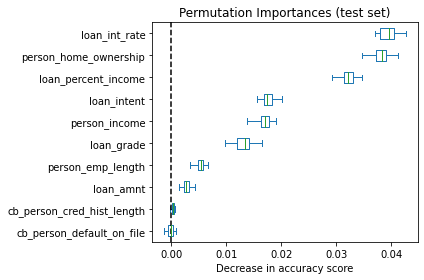

In [28]:
result = permutation_importance(rf_pipe, X_test, y_test, 
                                n_repeats=30, 
                                random_state= random_seed)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T, 
    columns=X_test.columns[sorted_importances_idx])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# 5. Modeling Without Low Features Importances

### 5.1 Data Transformation

In [29]:
data = df1.drop(columns = ['cb_person_default_on_file', 'cb_person_cred_hist_length'], axis = 1)

target = 'loan_status'
null_list = ['person_emp_length', 'loan_int_rate']
num_col = [col for col in data.select_dtypes(exclude ='object') if col != target]
cat_col = [col for col in data.select_dtypes(include ='object')]

In [30]:
X = data.drop(columns = target)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = test_size, random_state = random_seed)

In [31]:
num_imputer = IterativeImputer(initial_strategy='median', 
                               random_state = random_seed,
                               sample_posterior = True)

scaler = RobustScaler()
encoder = OneHotEncoder(handle_unknown="ignore")

num_transformer = make_pipeline(num_imputer)
scaler_transformer = make_pipeline(num_transformer, scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, null_list), 
                  ('scale', scaler_transformer, num_col),
                  ('cat', cat_transformer, cat_col),])

### 5.2 Random Forest Modeling

In [32]:
random_forest_parameters = {'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}
model_name = RandomForestClassifier(n_jobs=-1, random_state=random_seed, **random_forest_parameters)

rf_pipe_new = make_pipeline(preprocessor,model_name)

In [33]:
rf_pipe_new.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=0,
                                                                                    sample_posterior=True))]),
                                                  ['person_emp_length',
                                                   'loan_int_rate']),
                                                 ('scale',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('iterativeimputer',
                                                                                    IterativeImputer(initial_strategy='median'...
                                                  ['person_income', 'loan_amnt',
                                                   'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'person_emp_length',
                                                   'loan_intent',
                                                   'loan_grade'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=102,
                                        n_jobs=-1, random_state=0))])

In [34]:
y_true = y_test
y_pred = rf_pipe_new.predict(X_test)
print('RF_model: recall:', recall_score(y_true, y_pred))
print('RF_model: precision:',precision_score(y_true, y_pred))
print('RF_model: F1 Score:', f1_score(y_true, y_pred))
print('RF_model: accuracy:', accuracy_score(y_true, y_pred))

RF_model: recall: 0.5450516986706057
RF_model: precision: 0.9626086956521739
RF_model: F1 Score: 0.6960075447972336
RF_model: accuracy: 0.901074168797954


### 5.3 Reglog Model

In [35]:
model_name = LogisticRegression(random_state = random_seed)
reglog_pipe = make_pipeline(preprocessor, model_name)

reglog_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=0,
                                                                                    sample_posterior=True))]),
                                                  ['person_emp_length',
                                                   'loan_int_rate']),
                                                 ('scale',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('iterativeimputer',
                                                                                    IterativeImputer(initial_strategy='median',
                                                                                                     random_state=0,
                                                                                                     sample_posterior=True))])),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['person_income', 'loan_amnt',
                                                   'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'person_emp_length',
                                                   'loan_intent',
                                                   'loan_grade'])])),
                ('logisticregression', LogisticRegression(random_state=0))])

In [36]:
y_true = y_test
y_pred = reglog_pipe.predict(X_test)
print('Reglog_model: recall:', recall_score(y_true, y_pred))
print('Reglog_model: precision:',precision_score(y_true, y_pred))
print('Reglog_model: F1 Score:', f1_score(y_true, y_pred))
print('Reglog_model: accuracy:', accuracy_score(y_true, y_pred))

Reglog_model: recall: 0.5711472181191531
Reglog_model: precision: 0.7374443738080102
Reglog_model: F1 Score: 0.6437291897891232
Reglog_model: accuracy: 0.8686445012787724


### 5.4 CatBoostClassifier

In [37]:
model_name = cat.CatBoostClassifier(iterations=500, verbose=100,eval_metric="Recall")
catboost_pipe_new = make_pipeline(preprocessor,model_name)

catboost_pipe_new.fit(X_train,y_train)

Learning rate set to 0.073938
0:	learn: 0.6261572	total: 112ms	remaining: 55.7s
100:	learn: 0.7191255	total: 3.71s	remaining: 14.7s
200:	learn: 0.7329131	total: 7.43s	remaining: 11.1s
300:	learn: 0.7455190	total: 10.9s	remaining: 7.2s
400:	learn: 0.7565491	total: 14.5s	remaining: 3.58s
499:	learn: 0.7685641	total: 18.4s	remaining: 0us


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=0,
                                                                                    sample_posterior=True))]),
                                                  ['person_emp_length',
                                                   'loan_int_rate']),
                                                 ('scale',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('iterativeimputer',
                                                                                    IterativeImputer(initial_strategy='median'...
                                                                                                     sample_posterior=True))])),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['person_income', 'loan_amnt',
                                                   'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'person_emp_length',
                                                   'loan_intent',
                                                   'loan_grade'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000025608CC9780>)])

In [38]:
y_true = y_test
y_pred = catboost_pipe_new.predict(X_test)
print('Catboost_model: recall:', recall_score(y_true, y_pred))
print('Catboost_model: precision:',precision_score(y_true, y_pred))
print('catboost_model: F1 Score:', f1_score(y_true, y_pred))
print('Catboost_model: accuracy:', accuracy_score(y_true, y_pred))

Catboost_model: recall: 0.7188577055637617
Catboost_model: precision: 0.9694555112881806
catboost_model: F1 Score: 0.8255583828102911
Catboost_model: accuracy: 0.9368797953964194


The best model to __predict loan_status__ is __CatBoostClassifier__ with model accurancy 93,7%